Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from keras import layers
from keras.models import Sequential

### Importing Skin Cancer Data


In [2]:
#The data by mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Define the path of train and test image
data_dir_train = pathlib.Path('/content/drive/MyDrive/MachineLearning/Convolutional-Neural-Networks/MelanomaDetection/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/drive/MyDrive/MachineLearning/Convolutional-Neural-Networks/MelanomaDetection/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
print(data_dir_test)
print(data_dir_train)

/content/drive/MyDrive/MachineLearning/Convolutional-Neural-Networks/MelanomaDetection/Skin cancer ISIC The International Skin Imaging Collaboration/Test
/content/drive/MyDrive/MachineLearning/Convolutional-Neural-Networks/MelanomaDetection/Skin cancer ISIC The International Skin Imaging Collaboration/Train


In [5]:

#In Python, the glob module is used to retrieve files/pathnames matching a specified pattern
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180
datasplitseed=123
v_split=0.2

Use 80% of the images for training, and 20% for validation.

In [7]:
# train dataset
#resize images to the size img_height*img_width
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=datasplitseed,
  validation_split=v_split,
  subset='training',
  image_size=(img_height,img_width),
  batch_size=batch_size

)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## validation dataset 
val_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=datasplitseed,
    validation_split=v_split,
    subset='validation',
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
#Data Labeling
# List out all the classes of skin cancer 
class_names = train_ds.class_names
print(class_names)
numberOfClasses =len(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
##### Visualize one instance of all the nine classes present in the dataset

In [11]:
# random index number for image generated
import random
image_index=random.randint(0,10)

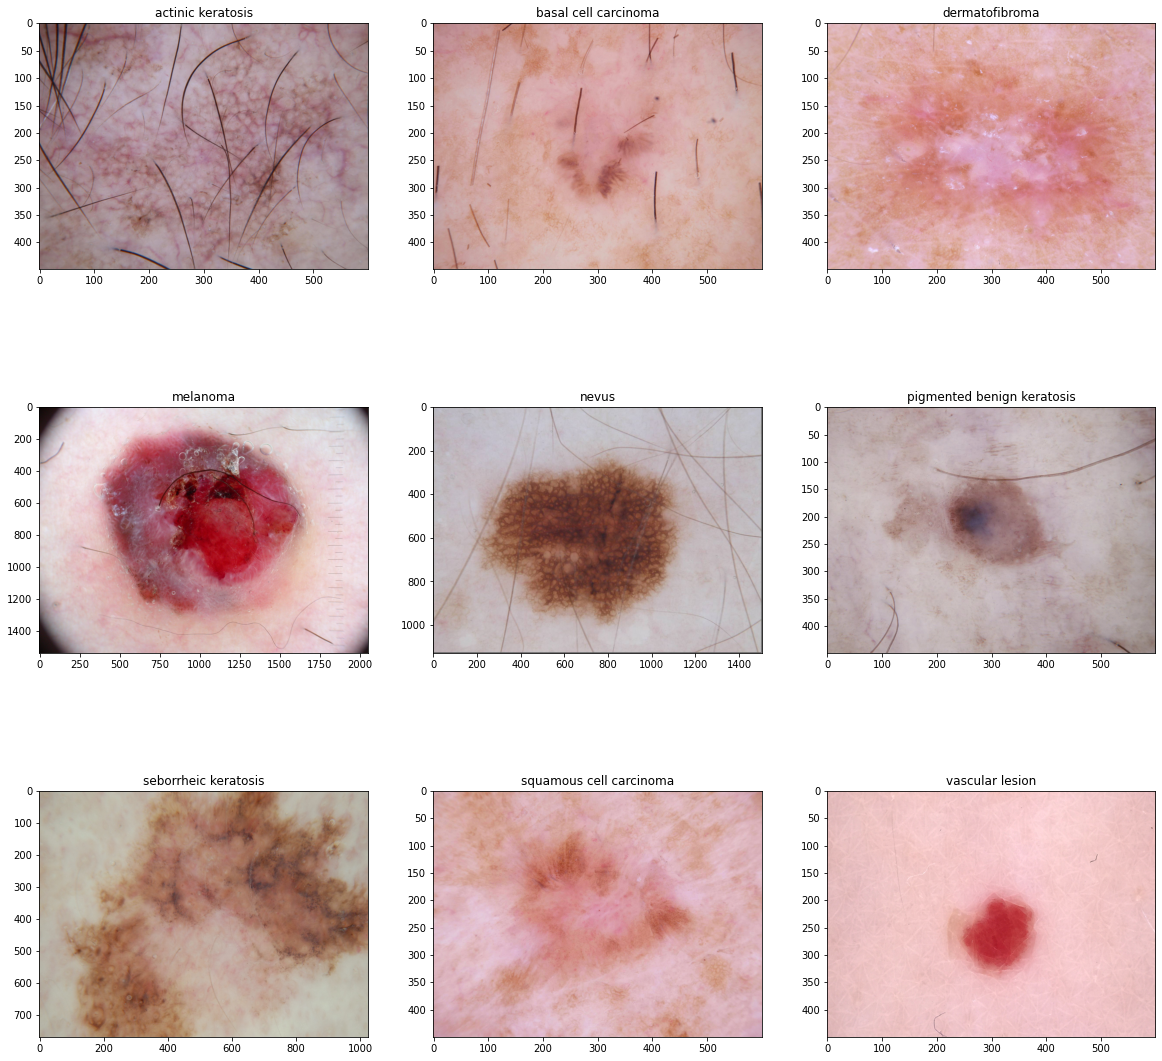

In [12]:
#import image visualization library
import matplotlib.image as mpimg
#Set fig Size
plt.figure(figsize=(20,20))
# Iterative Visualization of images of each class
for i in range(9):
  plt.subplot(3,3,i+1)
  image=mpimg.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[image_index]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model Building


In [14]:
#Neccessary Lib imports for Model 
from keras.layers import Dense ,Dropout , Flatten ,Conv2D ,MaxPool2D

#Constants for configuration
FILTERS=32
KERNEL_SIZE=(3,3)
STRIDE=1
CHANNELS=3

In [15]:
from keras.layers import Dense ,Dropout , Flatten ,Conv2D ,MaxPool2D
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


Model Building and Evaluation functions

In [16]:
#function to Add 1 convolution hidden Layers and 1 Max pool layers
def convolve(model,filters,kernel_size,batch_Norm,bias):
  model.add(Conv2D(filters=filters,kernel_size=kernel_size,padding='Same',activation='relu',use_bias=bias))
  model.add(MaxPool2D(pool_size=(2,2)))
  if apply_batchnorm:
    model.add(layers.BatchNormalization())
  return model


In [17]:
# Function for base model creation and tuning based on flag values
def create_tune_model(filters,apply_batchnorm=False,apply_dropout=False,bias=False):
  model1=Sequential([
                  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,CHANNELS))
                  ])
  model1=convolve(model1,filters,KERNEL_SIZE,apply_batchnorm,bias)
  filters=filters*2
  model1=convolve(model1,filters,KERNEL_SIZE,apply_batchnorm,bias)
  filters=filters*2
  model1=convolve(model1,filters,KERNEL_SIZE,apply_batchnorm,bias)
  filters=filters*2
  model1=convolve(model1,filters,KERNEL_SIZE,apply_batchnorm,bias)

  if apply_dropout:
    model1.add(Dropout(0.25))
  model1.add(Flatten())
  model1.add(Dense(filters, activation = "relu"))
  model1.add(Dense(filters/2, activation = "relu"))
  model1.add(Dense(numberOfClasses, activation = "softmax"))
  return model1

In [18]:
# Function for visualising evaulation results
def checkResults(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

###Create model without batch normalization, without droputs and without bias


In [19]:
#Parmeters for model Tuning
apply_batchnorm=False
apply_dropout=False
bias=False
#Initializing sequential model with normalized inputs.Eachpixel has value between 0 to 255. Rescaled that between 0 to 1
FILTERS=32

In [20]:
# Model Build
mymodel=create_tune_model(FILTERS,apply_batchnorm,apply_dropout,bias)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [21]:
from tensorflow.keras.optimizers import RMSprop
# Choose appropirate optimiser and loss function
mymodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
# View the summary of all layers
mymodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      864       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18432     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

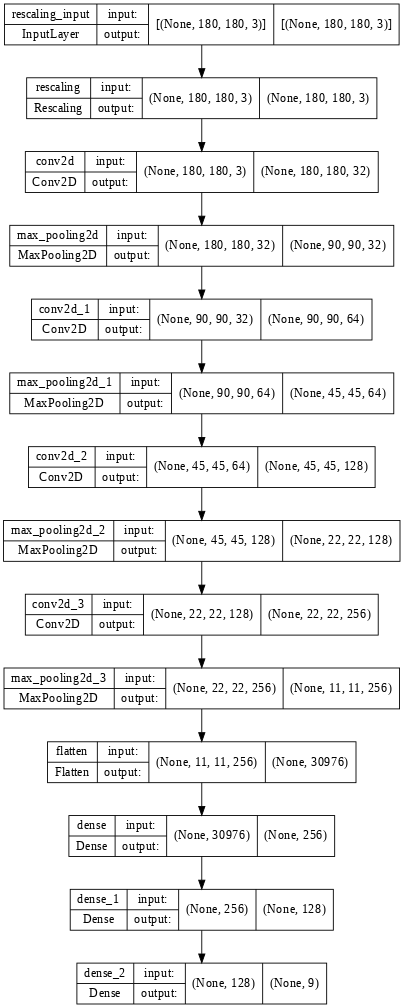

In [23]:
tf.keras.utils.plot_model(mymodel, show_shapes=True, dpi=64)

### Train the model

In [ ]:
epochs = 20
history = mymodel.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 322s 1s/step - loss: 2.0494 - accuracy: 0.2065 - val_loss: 1.9644 - val_accuracy: 0.2662
Epoch 2/20
56/56 [==============================] - 5s 81ms/step - loss: 1.8573 - accuracy: 0.3276 - val_loss: 1.7525 - val_accuracy: 0.3624
Epoch 3/20
56/56 [==============================] - 4s 79ms/step - loss: 1.7039 - accuracy: 0.3817 - val_loss: 1.6435 - val_accuracy: 0.3960
Epoch 4/20
56/56 [==============================] - 5s 81ms/step - loss: 1.5851 - accuracy: 0.4263 - val_loss: 1.5796 - val_accuracy: 0.4810
Epoch 5/20
56/56 [==============================] - 5s 81ms/step - loss: 1.4654 - accuracy: 0.4771 - val_loss: 1.5078 - val_accuracy: 0.4720
Epoch 6/20
56/56 [==============================] - 4s 79ms/step - loss: 1.4213 - accuracy: 0.5028 - val_loss: 1.4374 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 4s 78ms/step - loss: 1.3413 - accuracy: 0.5324 - val_loss: 1.3827 - val_accuracy: 0.5436
Epoch 8/20
56/56 [======

### Visualizing training results

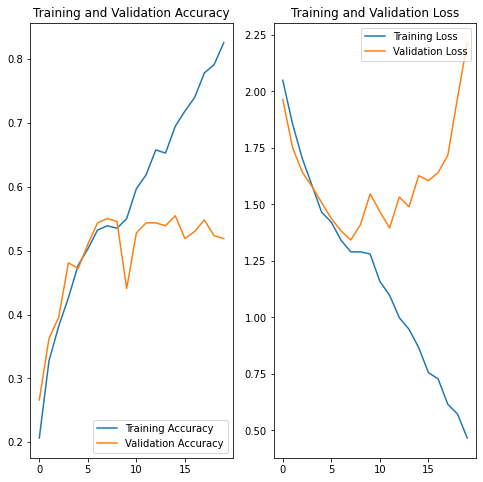

In [ ]:
checkResults(history)

###Findings on the first base model

**Initial findings**: 
The model is overfitting because overfitting is calculated w. r.t loss, and we can also see difference in loss functions in training & test around the 19-20th epoch

The **validation accuracy** is just around 50-60% because there are not enough features to remember the pattern, because the learning has just started


**Training accuracy**  82%

**Validation accuarcy** 52%





###Let's try Batch Normalization and bias

In [ ]:
#Parmeters for model Tuning
apply_batchnorm=True
bias=True
FILTERS=32

mymodel=create_tune_model(FILTERS,apply_batchnorm,apply_dropout,bias)

# Choose appropirate optimiser and loss function
mymodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# train
epochs = 20
history = mymodel.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 93ms/step - loss: 3.4810 - accuracy: 0.3270 - val_loss: 3.1498 - val_accuracy: 0.1119
Epoch 2/20
56/56 [==============================] - 5s 92ms/step - loss: 1.7553 - accuracy: 0.4475 - val_loss: 4.9180 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 5s 91ms/step - loss: 1.3968 - accuracy: 0.5268 - val_loss: 5.0023 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 5s 92ms/step - loss: 1.2318 - accuracy: 0.5748 - val_loss: 5.6300 - val_accuracy: 0.1812
Epoch 5/20
56/56 [==============================] - 5s 98ms/step - loss: 1.1544 - accuracy: 0.6183 - val_loss: 6.2616 - val_accuracy: 0.2282
Epoch 6/20
56/56 [==============================] - 5s 94ms/step - loss: 1.0776 - accuracy: 0.6311 - val_loss: 4.2058 - val_accuracy: 0.2908
Epoch 7/20
56/56 [==============================] - 5s 93ms/step - loss: 0.9247 - accuracy: 0.6674 - val_loss: 3.6580 - val_accuracy: 0.2550
Epoch 8/20
56

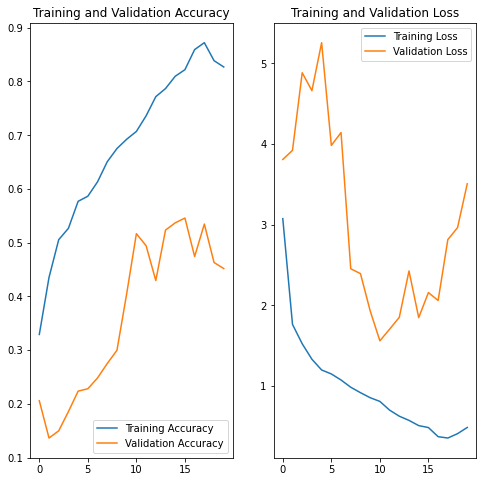

In [ ]:
#Evaulate Model
checkResults(history)

**Training accuracy**  92%

**Validation accuarcy** 52%





###Let's try Dropout also along with Batch Normalization and bias

In [ ]:
#Parmeters for model Tuning
apply_batchnorm=True
bias=True
apply_dropout=True
FILTERS=32

mymodel=create_tune_model(FILTERS,apply_batchnorm,apply_dropout,bias)

# Choose appropirate optimiser and loss function
mymodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# train
epochs = 30
history = mymodel.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 3s 53ms/step - loss: 2.9556 - accuracy: 0.3616 - val_loss: 2.9461 - val_accuracy: 0.1790
Epoch 2/30
56/56 [==============================] - 3s 52ms/step - loss: 1.7183 - accuracy: 0.4397 - val_loss: 2.6488 - val_accuracy: 0.1678
Epoch 3/30
56/56 [==============================] - 3s 53ms/step - loss: 1.4319 - accuracy: 0.5095 - val_loss: 3.0390 - val_accuracy: 0.1790
Epoch 4/30
56/56 [==============================] - 3s 52ms/step - loss: 1.2574 - accuracy: 0.5580 - val_loss: 6.4980 - val_accuracy: 0.2125
Epoch 5/30
56/56 [==============================] - 3s 53ms/step - loss: 1.1780 - accuracy: 0.5859 - val_loss: 4.1596 - val_accuracy: 0.2081
Epoch 6/30
56/56 [==============================] - 3s 53ms/step - loss: 1.0832 - accuracy: 0.6105 - val_loss: 2.7375 - val_accuracy: 0.2573
Epoch 7/30
56/56 [==============================] - 3s 54ms/step - loss: 1.0035 - accuracy: 0.6496 - val_loss: 3.3220 - val_accuracy: 0.2617
Epoch 8/30
56

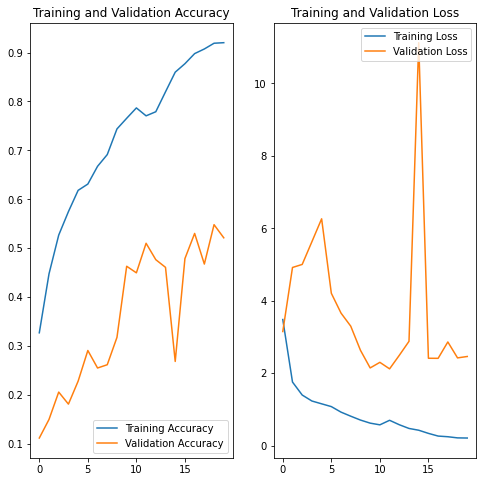

In [ ]:
#Evaulate Model
checkResults(history)

### Observations:
- Training Accuracy 92%
- Validation Accuracy 55%

- We see that model is highly **overfitting**


**Data Augmentation:** a technique to increase the diversity of your training set by applying random (but realistic) transformations, such as image rotation.

In [ ]:
#Choose an appropriate data augumentation strategy. 
data_aug=keras.Sequential([
                           tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                           tf.keras.layers.experimental.preprocessing.RandomRotation(0.2,fill_mode='reflect'),
                           tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(0.2,0.3),width_factor=(0.2,0.3),fill_mode='reflect')])

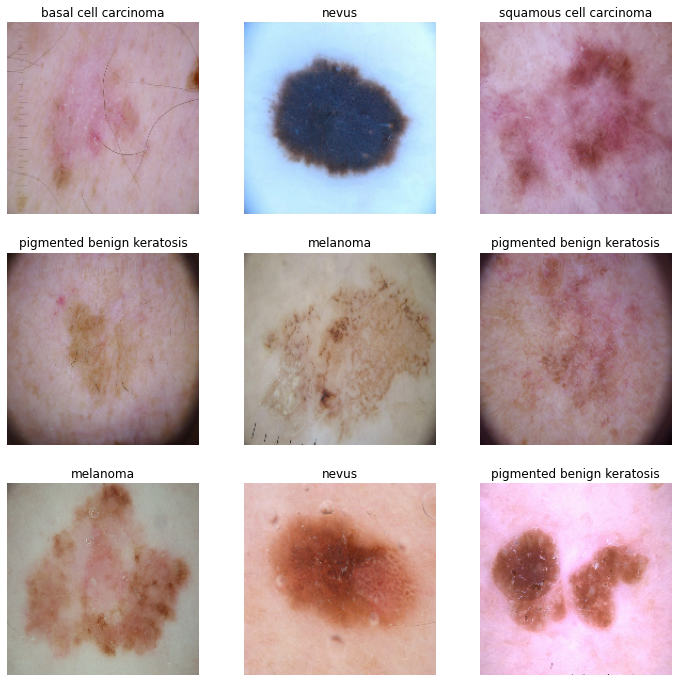

In [ ]:
# Visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_aug(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
filters=32
apply_batchnorm=True
bias=True
apply_dropout=True

model_Aug=Sequential([data_aug,
                  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,CHANNELS))
                  ])
model_Aug=convolve(model_Aug,filters,KERNEL_SIZE,apply_batchnorm,bias)
filters=filters*2
model1=convolve(model_Aug,filters,KERNEL_SIZE,apply_batchnorm,bias)
filters=filters*2
model1=convolve(model_Aug,filters,KERNEL_SIZE,apply_batchnorm,bias)
filters=filters*2
model1=convolve(model_Aug,filters,KERNEL_SIZE,apply_batchnorm,bias)

if apply_dropout:
  model_Aug.add(Dropout(0.25))
model_Aug.add(Flatten())
model_Aug.add(Dense(filters, activation = "relu"))
model_Aug.add(Dense(filters/2, activation = "relu"))
model_Aug.add(Dense(numberOfClasses, activation = "softmax"))


### Compiling the model

In [ ]:
model_Aug.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
#Train the model for 20 epochs
epochs = 20
history = model_Aug.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 111ms/step - loss: 3.2178 - accuracy: 0.3265 - val_loss: 4.5095 - val_accuracy: 0.1655
Epoch 2/20
56/56 [==============================] - 6s 111ms/step - loss: 1.8952 - accuracy: 0.4023 - val_loss: 3.3811 - val_accuracy: 0.2416
Epoch 3/20
56/56 [==============================] - 6s 110ms/step - loss: 1.5768 - accuracy: 0.4688 - val_loss: 4.2728 - val_accuracy: 0.1790
Epoch 4/20
56/56 [==============================] - 6s 110ms/step - loss: 1.4536 - accuracy: 0.4849 - val_loss: 3.6555 - val_accuracy: 0.1678
Epoch 5/20
56/56 [==============================] - 6s 110ms/step - loss: 1.3903 - accuracy: 0.5033 - val_loss: 4.0002 - val_accuracy: 0.1007
Epoch 6/20
56/56 [==============================] - 6s 111ms/step - loss: 1.3379 - accuracy: 0.5106 - val_loss: 3.6971 - val_accuracy: 0.1320
Epoch 7/20
56/56 [==============================] - 6s 110ms/step - loss: 1.2557 - accuracy: 0.5536 - val_loss: 2.2756 - val_accuracy: 0.2013
Epoch 

### Visualizing the results

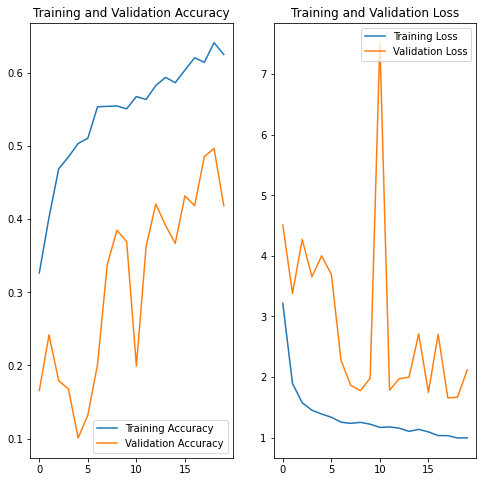

In [ ]:
checkResults(history)

**Findings:**

We don't see  improvements with respect to accuracy from the base model, but we can definitely see the overfitting issue fading away due to data augmentation




#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

#### Find the distribution of classes in the training dataset.

<BarContainer object of 9 artists>

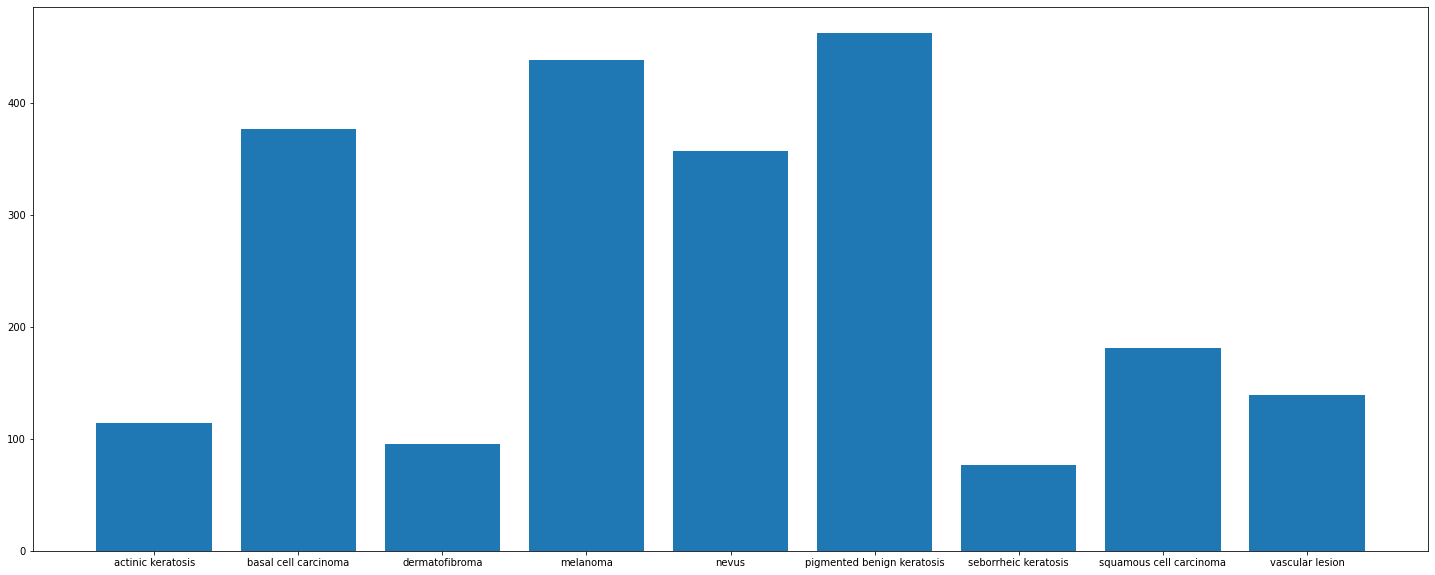

In [24]:
#plot number of images in each Class
count=[]
for class_ in class_names:
    count.append(len(list(data_dir_train.glob(class_+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

**Findings**
#### - Seborrheic keratosi class has the least number of samples.
#### - Pigmented Benign keratosis classes dominate the data in terms proportionate number of samples.



####  **Rectify the class imbalance**
#### **Context:** Use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
path_to_training_dataset=str(data_dir_train)+'/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.


Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/MachineLearning/Convolutional-Neural-Networks/MelanomaDetection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8AC62FE650>: 100%|██████████| 500/500 [00:18<00:00, 27.02 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/MachineLearning/Convolutional-Neural-Networks/MelanomaDetection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8BB6D3BD50>: 100%|██████████| 500/500 [00:19<00:00, 25.55 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/MachineLearning/Convolutional-Neural-Networks/MelanomaDetection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8AC6612650>: 100%|██████████| 500/500 [00:20<00:00, 24.47 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/MachineLearning/Convolutional-Neural-Networks/MelanomaDetection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F8B4576C590>: 100%|██████████| 500/500 [01:32<00:00,  5.43 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/MachineLearning/Convolutional-Neural-Networks/MelanomaDetection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8BCE7EF810>: 100%|██████████| 500/500 [01:13<00:00,  6.76 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/MachineLearning/Convolutional-Neural-Networks/MelanomaDetection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8AC6281890>: 100%|██████████| 500/500 [00:20<00:00, 24.91 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/MachineLearning/Convolutional-Neural-Networks/MelanomaDetection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F8AC6020F10>: 100%|██████████| 500/500 [00:41<00:00, 12.19 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/MachineLearning/Convolutional-Neural-Networks/MelanomaDetection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8AC6443C50>: 100%|██████████| 500/500 [00:18<00:00, 27.52 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/MachineLearning/Convolutional-Neural-Networks/MelanomaDetection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8AC638BE10>: 100%|██████████| 500/500 [00:19<00:00, 25.80 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

### Lets see the distribution of augmented data after adding new images to the original training data.

In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)


4500


<BarContainer object of 9 artists>

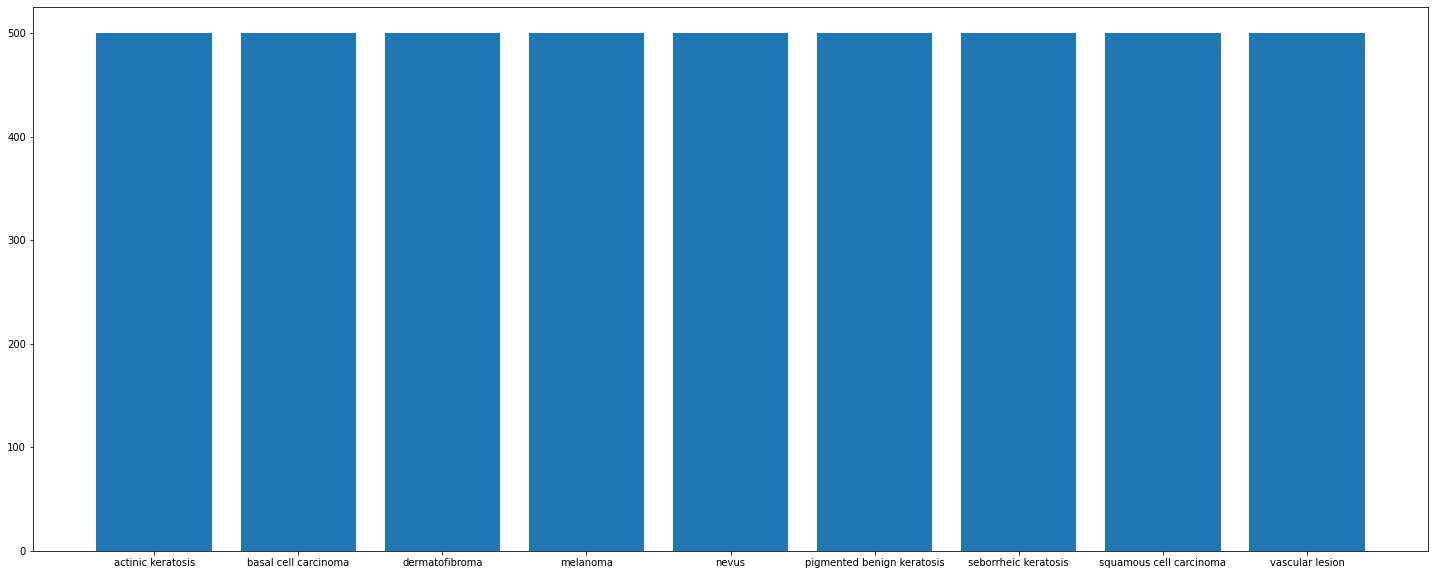

In [28]:
# Check the distribution of data again. 
count=[]
for class_ in class_names:
    count.append(len(list(data_dir_train.glob(class_+'*/output/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

In [29]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [30]:
#New augmented images list
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [31]:
# Get Existing images in Dataframe
path_list=[]
lesion_list=[]
for class_ in class_names:
  for file_ in data_dir_train.glob(class_+'/*.jpg'):
    path_list.append(str(file_))
    lesion_list.append(class_)

dataframe_dict_original=dict(zip(path_list,lesion_list))
original_df=pd.DataFrame(list(dataframe_dict_original.items()),columns=['Path','Label'])

In [32]:
#Appending the augmented data in existing 
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)


In [33]:
#check Combined list of data
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

####Train the model on the data created using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180
datasplitseed=123
v_split=0.2

####  Create a training dataset

In [35]:
#resize images to the size img_height*img_width
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=datasplitseed,
  validation_split=v_split,
  subset='training',
  image_size=(img_height,img_width),
  batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


####  Create a validation dataset

In [36]:
## validation dataset 
val_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=datasplitseed,
    validation_split=v_split,
    subset='validation',
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [37]:
apply_batchnorm=True
apply_dropout=True
bias=False
#Initializing sequential model with normalized inputs.Eachpixel has value between 0 to 255. Rescaled that between 0 to 1
FILTERS=32

mymodel=create_tune_model(FILTERS,apply_batchnorm,apply_dropout,bias)

####  Compile your model (Choose optimizer and loss function appropriately)

In [38]:
# Choose appropirate optimiser and loss function
mymodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

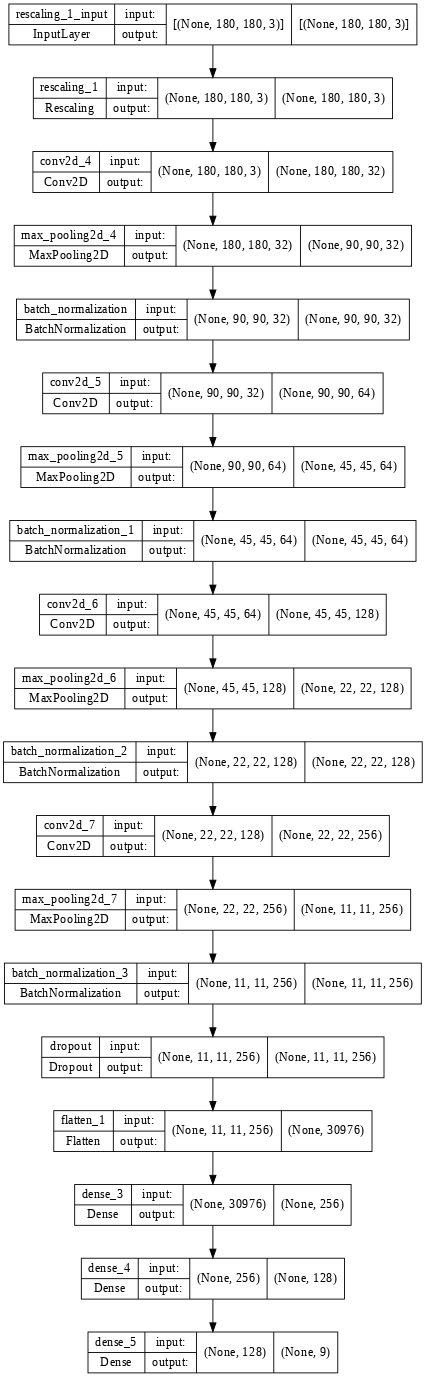

In [39]:
#Plot Model
tf.keras.utils.plot_model(mymodel, show_shapes=True, dpi=64)

#### Train your model

In [40]:
#Initializing earlystopping callback for training the model
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 30, 
                                        restore_best_weights = True)

In [41]:
# train
epochs = 50
history = mymodel.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks =[earlystopping]
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 43s 188ms/step - loss: 2.2524 - accuracy: 0.3735 - val_loss: 3.5772 - val_accuracy: 0.1373
Epoch 2/50
169/169 [==============================] - 32s 184ms/step - loss: 1.3220 - accuracy: 0.5193 - val_loss: 5.9486 - val_accuracy: 0.2056
Epoch 3/50
169/169 [==============================] - 32s 184ms/step - loss: 1.0492 - accuracy: 0.6183 - val_loss: 2.2738 - val_accuracy: 0.4358
Epoch 4/50
169/169 [==============================] - 33s 189ms/step - loss: 0.9411 - accuracy: 0.6500 - val_loss: 1.1404 - val_accuracy: 0.5805
Epoch 5/50
169/169 [==============================] - 32s 181ms/step - loss: 0.7054 - accuracy: 0.7383 - val_loss: 1.5645 - val_accuracy: 0.5330
Epoch 6/50
169/169 [==============================] - 31s 181ms/step - loss: 0.5984 - accuracy: 0.7776 - val_loss: 1.3108 - val_accuracy: 0.5947
Epoch 7/50
169/169 [==============================] - 31s 181ms/step - loss: 0.5325 - accuracy: 0.7990 - val_loss: 0.7532 - val_accuracy: 0.7

####   Visualize the model results

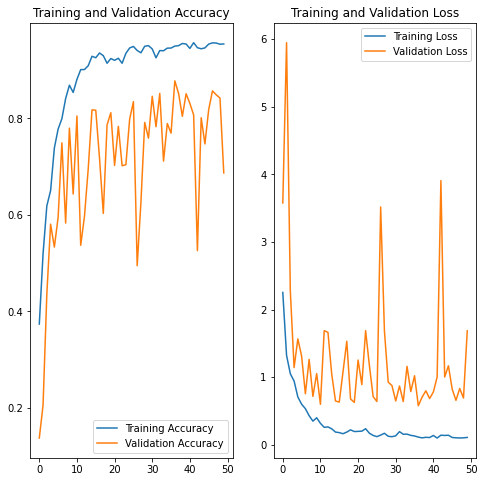

In [42]:
epochs=50
checkResults(history)


##**Analysis On Final Model**
TRAIN ACCURACY='95%'

VALLIDATION_ACCURACY='84%'

- The model is not overfitting and due to augmentation the accuracy has significantly increased
- Yes class rebalance helped here, as its important to balance out the data set or at least get it close to balance it in


**Evaulation of Model on Tets data**

In [43]:
## test dataset 
test_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=datasplitseed,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 118 files belonging to 9 classes.


In [44]:
loss_test,accuracy_test=mymodel.evaluate(test_ds,batch_size=batch_size)
print("Loss of Tets Data is:",loss_test)
print("Accuracy of Tets Data is:",accuracy_test)

4/4 [==============================] - 22s 41ms/step - loss: 8.1510 - accuracy: 0.3390
Loss of Tets Data is: 8.150984764099121
Accuracy of Tets Data is: 0.33898305892944336


##**Making prediction for Test Data**

In [53]:
#Load a random File from test data
import random

classindex=random.randint(0,8)
imageindex=random.randint(0,9)

test_image_path=list(data_dir_test.glob(class_names[classindex]+'/*.jpg'))[imageindex]
print(test_image_path)
print("Selecting test image of class ", class_names[classindex])

#Data transformation similar to train data
img = tf.keras.utils.load_img(test_image_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
print(img_array.shape)

#Data rescalling similar to train data
#img_array = img_array/255 # Rescaling
img_array = tf.expand_dims(img_array, 0) # Create a batch
print(img_array.shape)

/content/drive/MyDrive/MachineLearning/Convolutional-Neural-Networks/MelanomaDetection/Skin cancer ISIC The International Skin Imaging Collaboration/Test/dermatofibroma/ISIC_0024318.jpg
Selecting test image of class  dermatofibroma
(180, 180, 3)
(1, 180, 180, 3)


In [54]:
#Making Prediction on test image 
predictions = mymodel.predict(img_array)
score = tf.nn.softmax(predictions[0])
score

<tf.Tensor: shape=(9,), dtype=float32, numpy=
array([0.09333663, 0.09335192, 0.25317645, 0.09332919, 0.09333091,
       0.09348708, 0.09332915, 0.09332946, 0.09332919], dtype=float32)>

In [55]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to dermatofibroma with a 25.32 percent confidence.
